In [1]:
import jax 
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from functools import partial 
import numpy as np 

In [44]:
figure_folder = './../../../../instrumental_llms/figures/'

In [33]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/Newsreader-Italic-VariableFont_opsz,wght.ttf


In [34]:
def sample(fstage, key):
    k1, k2, k3 = jax.random.split(key, 3)
    z = jax.random.bernoulli(k1).astype(jnp.float32)
    d = jax.random.bernoulli(k2, p=jnp.where(z==1, fstage, 0.)).astype(jnp.float32)
    y = 1.*d + 0.1*jax.random.normal(k3)
    return z, d, y


def batch_sample(fstage, n, key):
    return jax.vmap(partial(sample, fstage))(jax.random.split(key, n))

In [35]:
def run(v, n, key):
    Z, D, Y = batch_sample(v, n, key)
    num = np.mean(Y, where=Z==1) - np.mean(Y, where=Z==0) 
    denom = (np.mean(D, where=Z==1) - np.mean(D, where=Z==0) )
    return num / denom

In [36]:
xs = np.linspace(0.05, 1., 30)
r_std = {}
r_mean = {}
for j in [100, 200, 500, 1000, 5000, 10000]:
    r_std[j] = []
    r_mean[j] = []
    for i in xs:
        results = jax.vmap(partial(run, i, j))(jax.random.split(jax.random.PRNGKey(0), 1000))
        r_std[j].append(jnp.std(results))
        r_mean[j].append(jnp.mean(results))

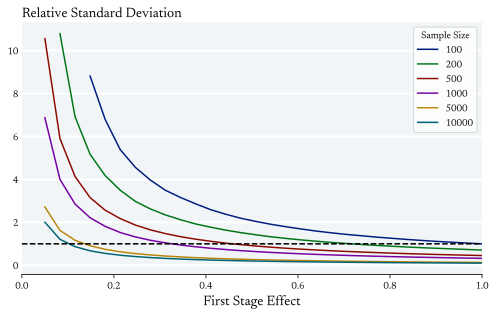

In [45]:

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Relative Standard Deviation', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
for key in r_std.keys():
    plt.plot(xs, jnp.array(r_std[key])/r_std[100][-1], label=key)
plt.axhline(1, color='black', linestyle='--')
plt.xlim(0, 1)
plt.legend(title='Sample Size')
plt.xlabel('First Stage Effect', size=14)
fig.savefig(figure_folder + 'fstage_sample_size.png')
plt.show()

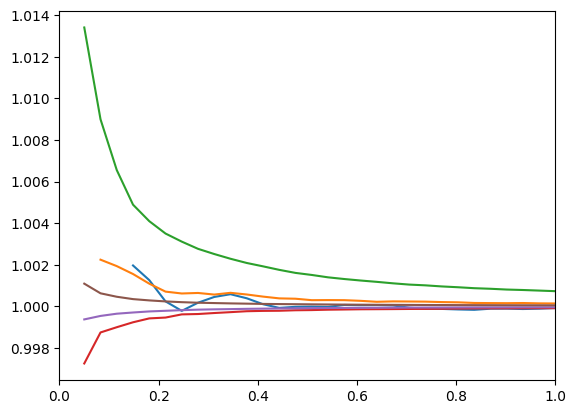

In [29]:
for key in r_std.keys():
    plt.plot(xs, jnp.array(r_mean[key]))
plt.xlim(0, 1)
plt.show()

In [18]:
def run_iv(v, n, key):
    Z, D, Y = batch_sample(v, n, key)
    Z, D, Y = Z.reshape(-1,1), D.reshape(-1,1), Y.reshape(-1,1)
    X = jnp.ones_like(Z)
    Dhat_xz =  jnp.hstack((X, Z)) @ jnp.linalg.lstsq(jnp.hstack((X, Z)), D)[0]
    Dhat_x = X @ jnp.linalg.lstsq(X, D)[0]
    residuals = Dhat_xz - Dhat_x
    return jnp.linalg.lstsq(jnp.hstack((residuals, X)), Y)[0][0]

In [20]:
xs = np.linspace(0.05, 1., 30)
r_std = {}
r_mean = {}
for j in [100, 200, 500, 1000, 5000, 10000]:
    r_std[j] = []
    r_mean[j] = []
    for i in xs:
        results = jax.vmap(partial(run_iv, i, j))(jax.random.split(jax.random.PRNGKey(0), 1000))
        r_std[j].append(jnp.std(results))
        r_mean[j].append(jnp.mean(results))

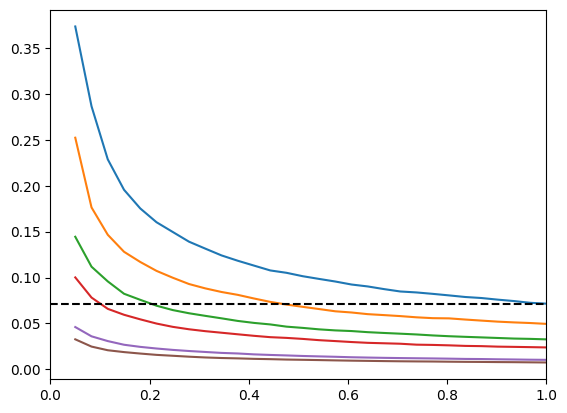

In [21]:
for key in r_std.keys():
    plt.plot(xs, jnp.array(r_std[key]))
plt.axhline(r_std[100][-1], color='black', linestyle='--')
plt.xlim(0, 1)
plt.show()